In [136]:
import requests
from requests.auth import HTTPProxyAuth
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
from time import sleep

# Сбор Данных (Парсим продолжительность песни)

In [137]:
pd.set_option('display.max_columns', 30)  # установим нужный размер отображения таблицы

In [138]:
df = pd.read_csv('/content/Five_years_of_Russian_Rap_Dataset.csv')
df.head()

,track_id,artist_name,Song_Success,album_release_date,hit_n,Drums_Energy,Drums_Complexity,Variety_of_musical_instruments,Mixing_Quality,Harmonic_Richness,Mixing_Character,Emotional_Intensity,is_feat,n_feat,status_guest,higher_guest,album_name,album_type,track_number,explicit,key_name,mode_name,key_mode,artists_all,remake,artist_id,album_id,download_link
0,5OFMeePbu2eEX1Hyf2tzYj,044 ROSE,hit,2017-06-23,0,1.748407,0.531356,0.677570,0.595927,1.209290,1.320058,1.661759,True,1,"0,1",1,ФОРМУЛА 1,single,1,True,G#,major,G# major,LIL MORTY; 044 ROSE,original,2V8aJ7qCArKAmHAX7u81Sj,4lsz5FpE3SFVuniECODcNN,https://p.scdn.co/mp3-preview/c37091967a02a815...
1,29kkmN00FdzizRg5xrVmBF,044 ROSE,none,2017-12-08,1,0.714910,1.291384,0.735496,0.669723,0.673321,1.021614,0.460496,True,1,1,0,Mandolina (feat. 044 ROSE),single,1,True,C,major,C major,ВАЙС; 044 ROSE,original,2V8aJ7qCArKAmHAX7u81Sj,6jnftxbUPDmmpOgt9gdvFb,https://p.scdn.co/mp3-preview/04d4f628d8305b88...
2,7L1tQKY6mcy0sGXntrABgW,044 ROSE,none,2018-02-13,1,0.778734,0.574680,0.950734,0.516571,0.672520,0.746304,1.007762,False,0,NaN,0,Альбом 044,album,1,True,B,major,B major,044 ROSE,original,2T1bAXQppVRoSNm63zcvzI,2Ib1KBcvNVWMHl5txJgk5l,https://p.scdn.co/mp3-preview/a257eed4179821af...
3,4jwDiUBqLQCCuyWkbX87qN,044 ROSE,none,2018-02-13,1,1.291229,0.561352,0.688906,0.514869,1.160833,0.977034,1.069928,True,1,"1,2",1,Альбом 044,album,2,True,G#,major,G# major,044 ROSE; LIL MORTY,original,2V8aJ7qCArKAmHAX7u81Sj,2Ib1KBcvNVWMHl5txJgk5l,https://p.scdn.co/mp3-preview/91fedfb65d95d8bd...
4,2DYUk5AkUV7kPTvd58LVCw,044 ROSE,none,2018-02-13,1,0.900054,0.551893,0.600117,0.786980,0.530228,1.006494,0.458813,False,0,NaN,0,Альбом 044,album,3,True,B,minor,B minor,044 ROSE,original,2T1bAXQppVRoSNm63zcvzI,2Ib1KBcvNVWMHl5txJgk5l,https://p.scdn.co/mp3-preview/e312514b3efa7d10...


In [139]:
# извлекаем айди песен (пригодится для поиска)
track_id = df['track_id'].unique()
len(track_id)

12743

Уникальных айдишек меньше чем строк в датасете, потому что фиты встречаются по несколько раз (при анализе это будет учтено). Фиты расписаны по каждому актёру, например:

In [140]:
df[['track_id', 'is_feat', 'album_name', 'artist_name', 'artists_all']][df['track_id'] == '5OFMeePbu2eEX1Hyf2tzYj']

,track_id,is_feat,album_name,artist_name,artists_all
0,5OFMeePbu2eEX1Hyf2tzYj,True,ФОРМУЛА 1,044 ROSE,LIL MORTY; 044 ROSE
5673,5OFMeePbu2eEX1Hyf2tzYj,True,ФОРМУЛА 1,LIL MORTY,LIL MORTY; 044 ROSE


**Приступаем непосредственно к парсингу :**

Интересный факт: пока ждёшь конца парсинга, можно успеть слетать до Грузии (а мб и обратно)

In [141]:
def skam(link):
  # задаем прокси, чтобы никто не узнал откуда мы
  proxies = {'http': 'http://146.247.117.207:8161'}
  auth = HTTPProxyAuth('user180567', 'nae7rp')

  # получаем доступ к сайту
  response = requests.get(
  url=link,
  proxies=proxies,
  auth=auth,
  timeout=30,
  )
  return response

In [142]:
# Сюда отправляются ссылки, который первый раз не прошли
def parsing_again(lol):
  soup = BeautifulSoup(skam(lol).content, 'html.parser')
  time.sleep(0.5)
  song_time = soup.find_all('span')
  if len(song_time) < 3:
    return 'None'
  else:
    return song_time[2].text

In [143]:
def song_parsing(i):
  song_link = 'https://open.spotify.com/track/' + i
  soup = BeautifulSoup(skam(song_link).content, 'html.parser')
  time.sleep(0.5)
  song_time = soup.find_all('span')
  if len(song_time) < 3:
    return parsing_again(song_link)
  else:
    return song_time[2].text

Запускаем и ждём 3ч. 40мин.:

In [ ]:
time_d = {i: song_parsing(i)  for i in track_id}

KeyboardInterrupt: 

Создаем табличку и сохраняем её в отдельный файл (он будет прикреплён отдельно) - 'song_duration.csv':

In [ ]:
df_time = pd.DataFrame(list(time_d.items()), columns = ['track_id', 'song_duration'])
df_time.to_csv('song_duration.csv', encoding='utf-8')

**Соединим данные**

Подгружаем файл с парсенными данными

In [144]:
df_time = pd.read_csv('/content/song_duration.csv')
df_time = df_time.drop(['Unnamed: 0'], axis=1)
df_time.head()

,track_id,song_duration
0,5OFMeePbu2eEX1Hyf2tzYj,2:49
1,29kkmN00FdzizRg5xrVmBF,3:16
2,7L1tQKY6mcy0sGXntrABgW,2:07
3,4jwDiUBqLQCCuyWkbX87qN,2:49
4,2DYUk5AkUV7kPTvd58LVCw,2:07


Для начала проверим на наличие ненайденных данных, спойлер: их четыре (пока не понятно как так получилось, в словаре должны были отразиться значения 'None', но их не было ://)

In [145]:
df_time.isnull().sum()

track_id         0
song_duration    4
dtype: int64

исправим:

In [146]:
df_time_non_found = df_time[df_time[['track_id','song_duration']].isnull().any(axis=1)]
df_time_non_found

,track_id,song_duration
3076,61678kM5Gt3uErypuSKwYc,NaN
4448,1U3MfLJ6Fi18dxVGnriVdV,NaN
4449,62QpDyIbfoO7cx12scAdXB,NaN
7609,6YLCUZZDcZzeM0Wyq4ZW76,NaN


In [147]:
for i in df_time_non_found['track_id']:
  inx = df_time_non_found[df_time_non_found['track_id'] == i].index
  df_time.loc[inx,'song_duration'] = song_parsing(i)

df_time.isnull().sum()

track_id         0
song_duration    0
dtype: int64

Вроде все в порядке, но надо проверить нет ли песен с продолжительностью 0:00

In [148]:
df_time.loc[df_time['song_duration'] == '0:00']

,track_id,song_duration
10703,1FQXKa6MLD67CSTKu8xlcQ,0:00


In [149]:
df.loc[df['track_id'] == '1FQXKa6MLD67CSTKu8xlcQ']

,track_id,artist_name,Song_Success,album_release_date,hit_n,Drums_Energy,Drums_Complexity,Variety_of_musical_instruments,Mixing_Quality,Harmonic_Richness,Mixing_Character,Emotional_Intensity,is_feat,n_feat,status_guest,higher_guest,album_name,album_type,track_number,explicit,key_name,mode_name,key_mode,artists_all,remake,artist_id,album_id,download_link
11877,1FQXKa6MLD67CSTKu8xlcQ,Timati,none,2019-12-30,9,1.896684,0.572675,1.53034,0.612986,0.640018,1.707756,0.734521,True,1,9,0,С чистого листа,single,1,False,E,major,E major,Timati; Grigory Leps,original,3oLccEy7y6zTe1gCFHxuWr,6MJ6CNpSwCiFKVopQZCPsL,https://p.scdn.co/mp3-preview/431082d3e33a14c2...


Трек Тимати... Просто уберём его из датасета:

Важно заметить, что это фит, и он не дублируется в датасете, значит не все фиты дублируются

In [150]:
df = df.drop([11877])

In [151]:
df = pd.merge(df, df_time, how="left", on ='track_id')

In [152]:
df.head()

,track_id,artist_name,Song_Success,album_release_date,hit_n,Drums_Energy,Drums_Complexity,Variety_of_musical_instruments,Mixing_Quality,Harmonic_Richness,Mixing_Character,Emotional_Intensity,is_feat,n_feat,status_guest,higher_guest,album_name,album_type,track_number,explicit,key_name,mode_name,key_mode,artists_all,remake,artist_id,album_id,download_link,song_duration
0,5OFMeePbu2eEX1Hyf2tzYj,044 ROSE,hit,2017-06-23,0,1.748407,0.531356,0.677570,0.595927,1.209290,1.320058,1.661759,True,1,"0,1",1,ФОРМУЛА 1,single,1,True,G#,major,G# major,LIL MORTY; 044 ROSE,original,2V8aJ7qCArKAmHAX7u81Sj,4lsz5FpE3SFVuniECODcNN,https://p.scdn.co/mp3-preview/c37091967a02a815...,2:49
1,29kkmN00FdzizRg5xrVmBF,044 ROSE,none,2017-12-08,1,0.714910,1.291384,0.735496,0.669723,0.673321,1.021614,0.460496,True,1,1,0,Mandolina (feat. 044 ROSE),single,1,True,C,major,C major,ВАЙС; 044 ROSE,original,2V8aJ7qCArKAmHAX7u81Sj,6jnftxbUPDmmpOgt9gdvFb,https://p.scdn.co/mp3-preview/04d4f628d8305b88...,3:16
2,7L1tQKY6mcy0sGXntrABgW,044 ROSE,none,2018-02-13,1,0.778734,0.574680,0.950734,0.516571,0.672520,0.746304,1.007762,False,0,NaN,0,Альбом 044,album,1,True,B,major,B major,044 ROSE,original,2T1bAXQppVRoSNm63zcvzI,2Ib1KBcvNVWMHl5txJgk5l,https://p.scdn.co/mp3-preview/a257eed4179821af...,2:07
3,4jwDiUBqLQCCuyWkbX87qN,044 ROSE,none,2018-02-13,1,1.291229,0.561352,0.688906,0.514869,1.160833,0.977034,1.069928,True,1,"1,2",1,Альбом 044,album,2,True,G#,major,G# major,044 ROSE; LIL MORTY,original,2V8aJ7qCArKAmHAX7u81Sj,2Ib1KBcvNVWMHl5txJgk5l,https://p.scdn.co/mp3-preview/91fedfb65d95d8bd...,2:49
4,2DYUk5AkUV7kPTvd58LVCw,044 ROSE,none,2018-02-13,1,0.900054,0.551893,0.600117,0.786980,0.530228,1.006494,0.458813,False,0,NaN,0,Альбом 044,album,3,True,B,minor,B minor,044 ROSE,original,2T1bAXQppVRoSNm63zcvzI,2Ib1KBcvNVWMHl5txJgk5l,https://p.scdn.co/mp3-preview/e312514b3efa7d10...,2:07


# 0: Немного о признаках:




* track_id - id номер на Spotify (не уникальный из-за фитов)
* artist_name - имя исполнителя
* Song_Success - категориальный признак: успешность композиции
* album_release_date - дата релиза альбома
* hit_n - количество хитов ранее у этого исполнителя
* Drums_Energy
* Drums_Complexity
* Variety_of_musical_instruments
* Mixing_Quality
* Harmonic_Richness
* Mixing_Character
* Emotional_Intensity
* is_feat - категориальный признак: фит или не фит
* n_feat - количество приглашенных в фит артистов
* status_guest - количество хитов у гостевых артистов суммарно
* higher_guest - бинарный признак: у приглашенного артиста хитов больше чем у того, кто выпускает трек
* album_name - название альбома
* album_type - категориальный признак: single, album или compilation. Сингл – это вид альбома, содержащий один трек.
* song_duration - время продолжительности трека: в минутах


**Выделенное жирным буду удалять**

# 1. Гипотезы

Ниже указаны гипотезы которые будем проверять:
1. У музыкальных фитов больше шансов стать популярными, чем у треков в соло?
2. Как звуковые характеристики влияют на успешность трека? Есть ли некоторый шаблон или технически уникальному треку проще стать популярным? Что лучше разнообразный трек или жесткий бит 3 минуты норм?
3. Исполнители с большим количеством предыдущих хитов имеют больше шансов на создание нового хита?
4. Как содержание песни влияет на успех? Сколько раз надо сказать "блять", чтобы песня стала взорвала чарты?
6. В разное время года люди предпочитают разные типы музыки (зимой - мажор, летом - минор). Проверить взаимосвязь между настроением успешной песни и временем года.


---


4. Что выстреливает больше ремейк или оригинал?
5. В какое время года выходит больше всего хитов? Связь между датой выпуска альбома и успешностью песни
6. Как номер трека в альбоме влияет на его популярность?


6. Связь между длительностью песни и ее успешностью? (спарсить минуты со спотифая)
7. Как содержание песни влияет на успех? Сколько раз надо сказать "блять", чтобы песня стала взорвала чарты?
8. Можно ли после первого хита создать более успешный второй?
9. Смотрим в ретроспективе на творчество Фараона/Тимати/Славы кпсс

# 1.1 Предобработка

In [153]:
df.info() # такие типы данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14396 entries, 0 to 14395
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   track_id                        14396 non-null  object 
 1   artist_name                     14396 non-null  object 
 2   Song_Success                    14396 non-null  object 
 3   album_release_date              14396 non-null  object 
 4   hit_n                           14396 non-null  int64  
 5   Drums_Energy                    14396 non-null  float64
 6   Drums_Complexity                14396 non-null  float64
 7   Variety_of_musical_instruments  14396 non-null  float64
 8   Mixing_Quality                  14396 non-null  float64
 9   Harmonic_Richness               14396 non-null  float64
 10  Mixing_Character                14396 non-null  float64
 11  Emotional_Intensity             14396 non-null  float64
 12  is_feat                         

In [154]:
df.shape

(14396, 29)

In [155]:
df.isnull().sum()

track_id                             0
artist_name                          0
Song_Success                         0
album_release_date                   0
hit_n                                0
Drums_Energy                         0
Drums_Complexity                     0
Variety_of_musical_instruments       0
Mixing_Quality                       0
Harmonic_Richness                    0
Mixing_Character                     0
Emotional_Intensity                  0
is_feat                              0
n_feat                               0
status_guest                      8656
higher_guest                         0
album_name                           0
album_type                           0
track_number                         0
explicit                             0
key_name                             8
mode_name                            8
key_mode                             8
artists_all                          0
remake                               0
artist_id                

Что-то много скипнутых значений в столбце status_guest

In [156]:
df = df.drop('status_guest', axis=1)
df.head()

,track_id,artist_name,Song_Success,album_release_date,hit_n,Drums_Energy,Drums_Complexity,Variety_of_musical_instruments,Mixing_Quality,Harmonic_Richness,Mixing_Character,Emotional_Intensity,is_feat,n_feat,higher_guest,album_name,album_type,track_number,explicit,key_name,mode_name,key_mode,artists_all,remake,artist_id,album_id,download_link,song_duration
0,5OFMeePbu2eEX1Hyf2tzYj,044 ROSE,hit,2017-06-23,0,1.748407,0.531356,0.677570,0.595927,1.209290,1.320058,1.661759,True,1,1,ФОРМУЛА 1,single,1,True,G#,major,G# major,LIL MORTY; 044 ROSE,original,2V8aJ7qCArKAmHAX7u81Sj,4lsz5FpE3SFVuniECODcNN,https://p.scdn.co/mp3-preview/c37091967a02a815...,2:49
1,29kkmN00FdzizRg5xrVmBF,044 ROSE,none,2017-12-08,1,0.714910,1.291384,0.735496,0.669723,0.673321,1.021614,0.460496,True,1,0,Mandolina (feat. 044 ROSE),single,1,True,C,major,C major,ВАЙС; 044 ROSE,original,2V8aJ7qCArKAmHAX7u81Sj,6jnftxbUPDmmpOgt9gdvFb,https://p.scdn.co/mp3-preview/04d4f628d8305b88...,3:16
2,7L1tQKY6mcy0sGXntrABgW,044 ROSE,none,2018-02-13,1,0.778734,0.574680,0.950734,0.516571,0.672520,0.746304,1.007762,False,0,0,Альбом 044,album,1,True,B,major,B major,044 ROSE,original,2T1bAXQppVRoSNm63zcvzI,2Ib1KBcvNVWMHl5txJgk5l,https://p.scdn.co/mp3-preview/a257eed4179821af...,2:07
3,4jwDiUBqLQCCuyWkbX87qN,044 ROSE,none,2018-02-13,1,1.291229,0.561352,0.688906,0.514869,1.160833,0.977034,1.069928,True,1,1,Альбом 044,album,2,True,G#,major,G# major,044 ROSE; LIL MORTY,original,2V8aJ7qCArKAmHAX7u81Sj,2Ib1KBcvNVWMHl5txJgk5l,https://p.scdn.co/mp3-preview/91fedfb65d95d8bd...,2:49
4,2DYUk5AkUV7kPTvd58LVCw,044 ROSE,none,2018-02-13,1,0.900054,0.551893,0.600117,0.786980,0.530228,1.006494,0.458813,False,0,0,Альбом 044,album,3,True,B,minor,B minor,044 ROSE,original,2T1bAXQppVRoSNm63zcvzI,2Ib1KBcvNVWMHl5txJgk5l,https://p.scdn.co/mp3-preview/e312514b3efa7d10...,2:07


Пропусков больше половины в колонке status_guest - количество хитов у гостевых артистов, так как их очень много и связанные с этим признакам напрямую гипотезы мы неиспользуем, то убираем данную колонку. Так же есть 8 пропусков в признаках key_name, mode_name и key_mode, что с ними делать будем - определим чуть позже.


---





# 2. Визуализация

In [157]:
import seaborn as sns
import matplotlib.pyplot as plt

1) Какая вообще доля хитов в датасете?

In [158]:
df.Song_Success.value_counts(normalize=True) # здесь в целом распределение нашего таргета

Song_Success
none    0.815018
hit     0.184982
Name: proportion, dtype: float64

Доля хитов достаточно мала... Надо посмотреть как количество песен (в датасете) зависит от популярности артистов. Популярность реперов будем оценивать по количеству предыдущих хитов:

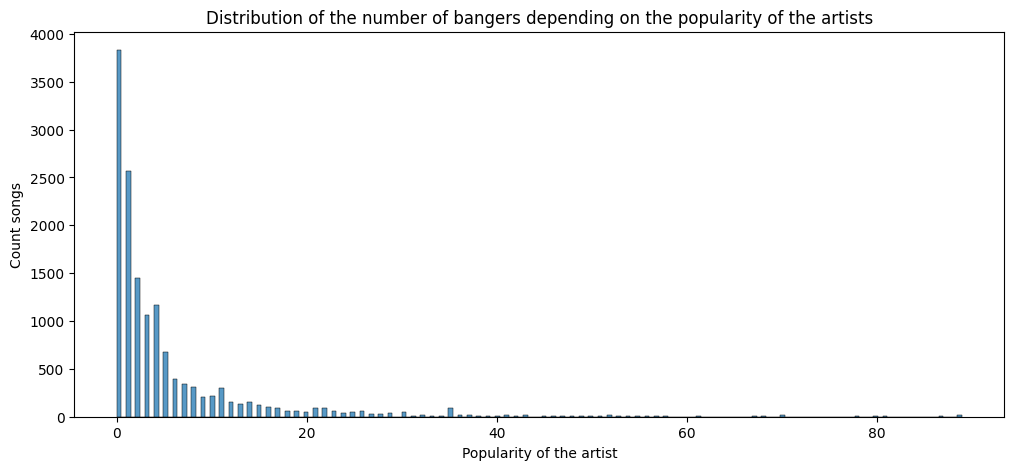

In [159]:
plt.figure(figsize = (12,5))
sns.histplot(x='hit_n', data=df)
plt.title('Distribution of the number of bangers depending on the popularity of the artists')
plt.xlabel('Popularity of the artist')
plt.ylabel('Count songs');

Небольшая доля хитов в датасете объясняется тем, что в датасете в основном собраны треки не очень популярных реперов.



<center>
<img src='https://cs14.pikabu.ru/post_img/2023/04/30/7/og_og_1682854967260964789.jpg'
" height="300">
</center>

2) Мы видим, что большая часть репчиков не выстреливает на российской эстраде. Надо бы конкретики выдать, поэтому теперь смотрим, что будет, если добавить еще реперов в трек. Вырастут ли шансы нашей демке залететь? Общую разбивку по таргету детализируем с помощью признака is_feat - является ли песня фитом или нет.

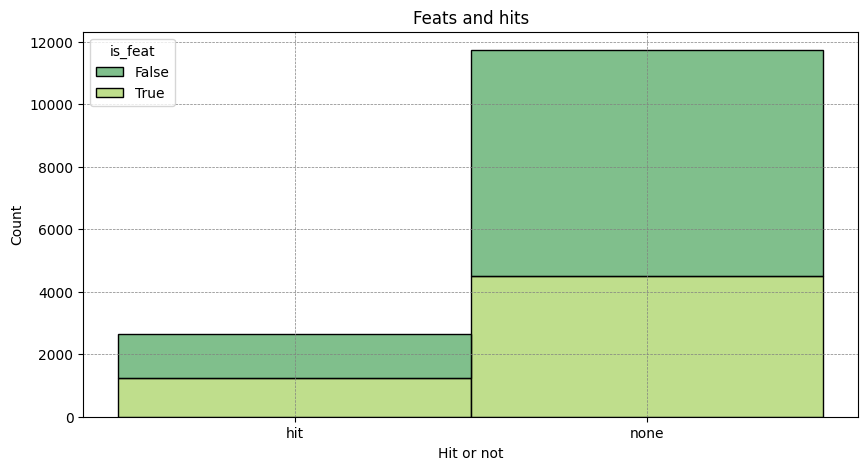

In [160]:
plt.figure(figsize = (10,5))
sns.histplot(x='Song_Success', hue = 'is_feat',data=df, palette = 'summer', multiple = 'stack')
plt.title('Feats and hits')
plt.xlabel('Hit or not')
plt.ylabel('Count')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5);

По графику видим что мощные бэнгеры в половине случаев записаны коллективно, да и в целом доля плохих песенок среди фитов меньше. Покажем это еще и численно: вышло по фактам


In [161]:
df[df.is_feat==True].Song_Success.value_counts(normalize=True)

Song_Success
none    0.782056
hit     0.217944
Name: proportion, dtype: float64

In [162]:
df[df.is_feat==False].Song_Success.value_counts(normalize=True)

Song_Success
none    0.836876
hit     0.163124
Name: proportion, dtype: float64

В целом коллективным бенгерам легче стать хитом, но разница не такая большая как мы предполагали

In [163]:
table = pd.pivot_table(df[['is_feat', 'hit_n', 'Song_Success']], index=['hit_n'],
                       columns=['is_feat'], aggfunc="count")
table

Song_Success        
is_feat        False   True 
hit_n                       
0             2534.0  1297.0
1             1574.0   990.0
2              773.0   680.0
3              640.0   426.0
4              748.0   416.0
...              ...     ...
80               NaN     3.0
81               2.0     9.0
87               NaN     3.0
88               NaN     1.0
89               2.0    13.0

[76 rows x 2 columns]

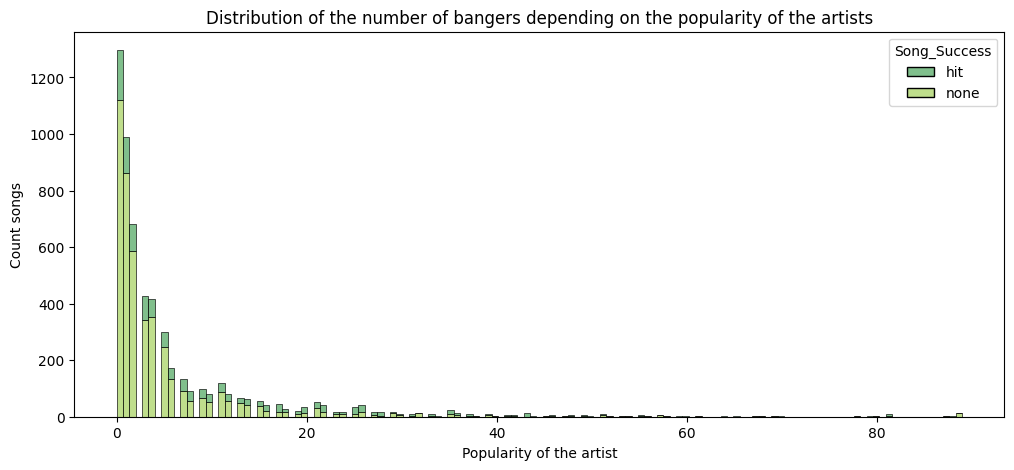

In [164]:
plt.figure(figsize = (12,5))
sns.histplot(x='hit_n', data=df.loc[df.is_feat==True], hue = 'Song_Success', palette = 'summer', multiple = 'stack')
plt.title('Distribution of the number of bangers depending on the popularity of the artists')
plt.xlabel('Popularity of the artist')
plt.ylabel('Count songs');

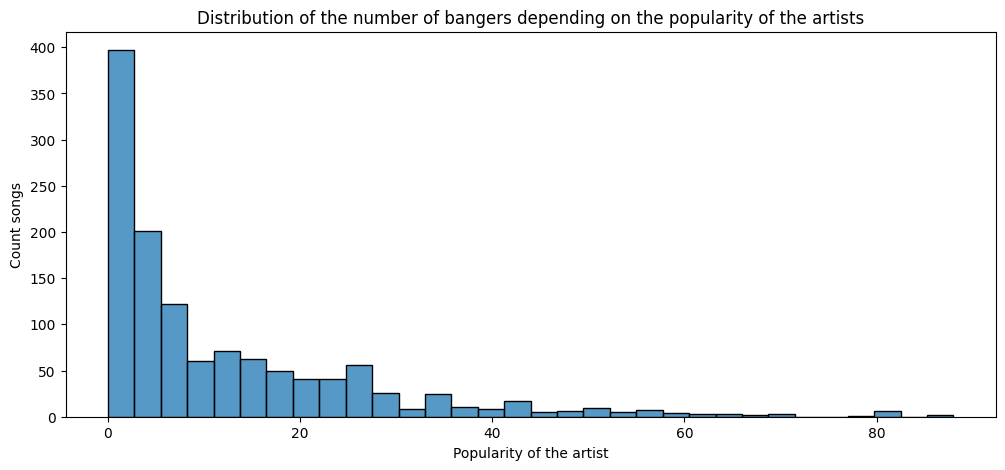

In [165]:
plt.figure(figsize = (12,5))
sns.histplot(x='hit_n', data=df.loc[(df.is_feat==True) & (df.Song_Success=='hit')])
plt.title('Distribution of the number of bangers depending on the popularity of the artists')
plt.xlabel('Popularity of the artist')
plt.ylabel('Count songs');

In [166]:
df['hit_n'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 17, 21,
       22, 23, 24, 15, 16, 18, 19, 20, 25, 39, 26, 27, 28, 36, 29, 30, 40,
       41, 42, 43, 49, 32, 33, 34, 35, 37, 38, 31, 48, 50, 52, 53, 54, 55,
       56, 57, 58, 44, 45, 46, 47, 51, 65, 66, 67, 59, 60, 61, 64, 68, 69,
       70, 78, 79, 80, 81, 87, 88, 89])

In [167]:
df.loc[df.is_feat==True].groupby(['hit_n']).agg({'Song_Success': ['count']})

,Song_Success
,count
hit_n,
0,1297
1,990
2,680
3,426
4,416
...,...
80,3
81,9


In [168]:
df[['higher_guest', 'hit_n']]

,higher_guest,hit_n
0,1,0
1,0,1
2,0,1
3,1,1
4,0,1
...,...,...
14391,0,1
14392,0,1
14393,0,1
14394,0,1


3) Чем больше мс в сборе, тем круче трек? Ну сейчас проверим

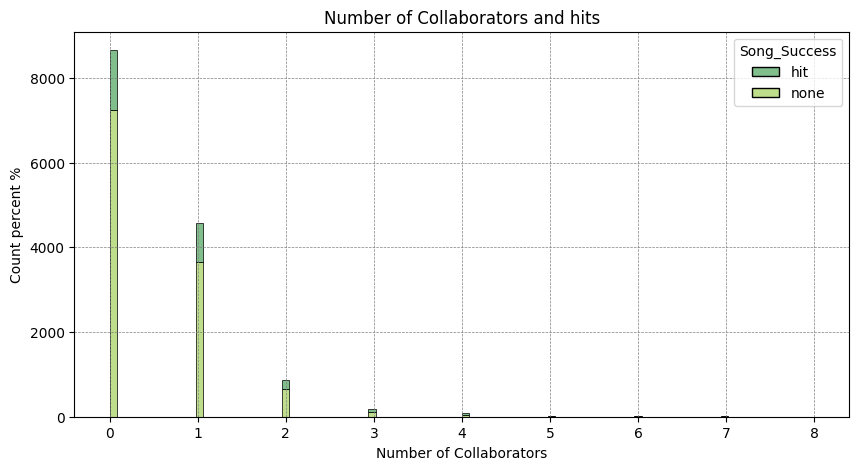

In [169]:
plt.figure(figsize = (10,5))
sns.histplot(x='n_feat', hue = 'Song_Success',data=df, palette = 'summer', multiple = 'stack')
plt.title('Number of Collaborators and hits')
plt.xlabel('Number of Collaborators')
plt.ylabel('Count percent %')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5);
plt.show()

In [170]:
df.groupby(by = 'n_feat')['Song_Success'].value_counts(normalize = True).unstack() #  в долях

Song_Success,hit,none
n_feat,,
0,0.163124,0.836876
1,0.201664,0.798336
2,0.242808,0.757192
3,0.379888,0.620112
4,0.350649,0.649351
5,0.454545,0.545455
6,0.500000,0.500000
7,0.545455,0.454545
8,NaN,1.000000


In [171]:
df.groupby(by = 'n_feat')['Song_Success'].value_counts().unstack() #  в абсолютном значении

Song_Success,hit,none
n_feat,,
0,1412.0,7244.0
1,921.0,3646.0
2,211.0,658.0
3,68.0,111.0
4,27.0,50.0
5,5.0,6.0
6,7.0,7.0
7,12.0,10.0
8,NaN,1.0


In [172]:
df[df['n_feat'] == 8] # самый редкий вид

,track_id,artist_name,Song_Success,album_release_date,hit_n,Drums_Energy,Drums_Complexity,Variety_of_musical_instruments,Mixing_Quality,Harmonic_Richness,Mixing_Character,Emotional_Intensity,is_feat,n_feat,higher_guest,album_name,album_type,track_number,explicit,key_name,mode_name,key_mode,artists_all,remake,artist_id,album_id,download_link,song_duration
4464,1yYZTAsYggKgr57OoE9roE,Jah Khalib,none,2019-10-29,12,3.28369,0.533046,1.787629,0.679632,0.895059,1.656954,0.749655,True,8,0,ВЫХОД В СВЕТ,album,14,True,G#,major,G# major,Jah Khalib; Big Som; HIRO; ISLA DE MUERTA; Jam...,original,4TjXA854eWs8P5EBgCbQmv,6MEQ5qpacZDlhcDD2gwtUm,https://p.scdn.co/mp3-preview/f6218a657157cbc3...,5:28


Гипотеза подтвердилась, ну почти. По последней строке вопросики есть конечно, тренд был очевиден: с увеличением тимы росли шансы выдать классный мотив, но вот закончилось все подозрительно странно: настолько большой гэнг (опасная восьмерка во главе с мистером Jah Khalibом) не выстрелил. Других наблюдений с такими же размером признака n_feat нет. Выводы какие можно сделать? Ну мне не понравилось, как-то однотипно.

А вообще сюда нужно больше наблюдений, чтобы теорию подтвердить, по понятным причинам треков с большим количеством исполнителей меньше в природе, наверное крайние значения 5-8 исполнителей можно считать выбросами даже

4) Грустный или веселый реп: что больше любит население?

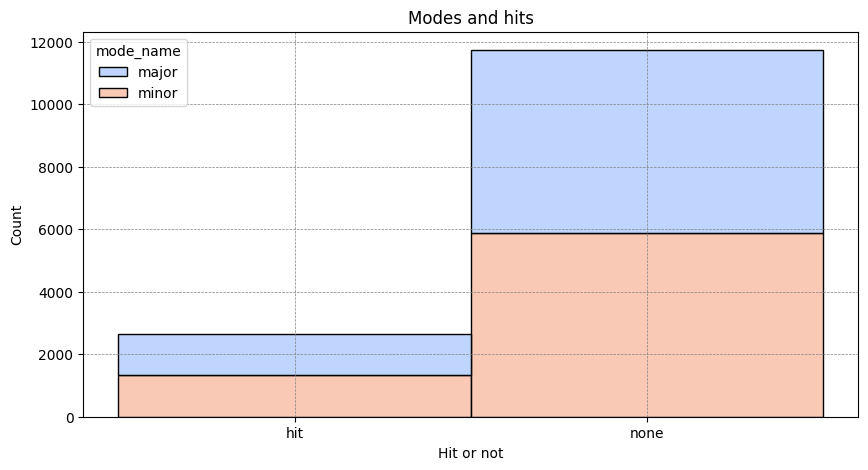

In [173]:
plt.figure(figsize = (10,5))
sns.histplot(x='Song_Success', hue = 'mode_name',data=df, palette = 'coolwarm', multiple = 'stack')
plt.title('Modes and hits')
plt.xlabel('Hit or not')
plt.ylabel('Count')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5);

Распределение тональностьй мажор/минор примерно одинаково как для популярных треков, так и для сомнительных композиций. Это мало полезный признак для задач классификации формата песня хит или нет хит.

5) Посмотрим на технические параметры песен, оценим их влияние на таргет

In [174]:
y_encoded = (df.Song_Success=='hit').astype('int') # таргет закодировали
tecnikal_info = df.select_dtypes(include = 'float64').join(y_encoded)
tecnikal_info.head()

,Drums_Energy,Drums_Complexity,Variety_of_musical_instruments,Mixing_Quality,Harmonic_Richness,Mixing_Character,Emotional_Intensity,Song_Success
0,1.748407,0.531356,0.677570,0.595927,1.209290,1.320058,1.661759,1
1,0.714910,1.291384,0.735496,0.669723,0.673321,1.021614,0.460496,0
2,0.778734,0.574680,0.950734,0.516571,0.672520,0.746304,1.007762,0
3,1.291229,0.561352,0.688906,0.514869,1.160833,0.977034,1.069928,0
4,0.900054,0.551893,0.600117,0.786980,0.530228,1.006494,0.458813,0


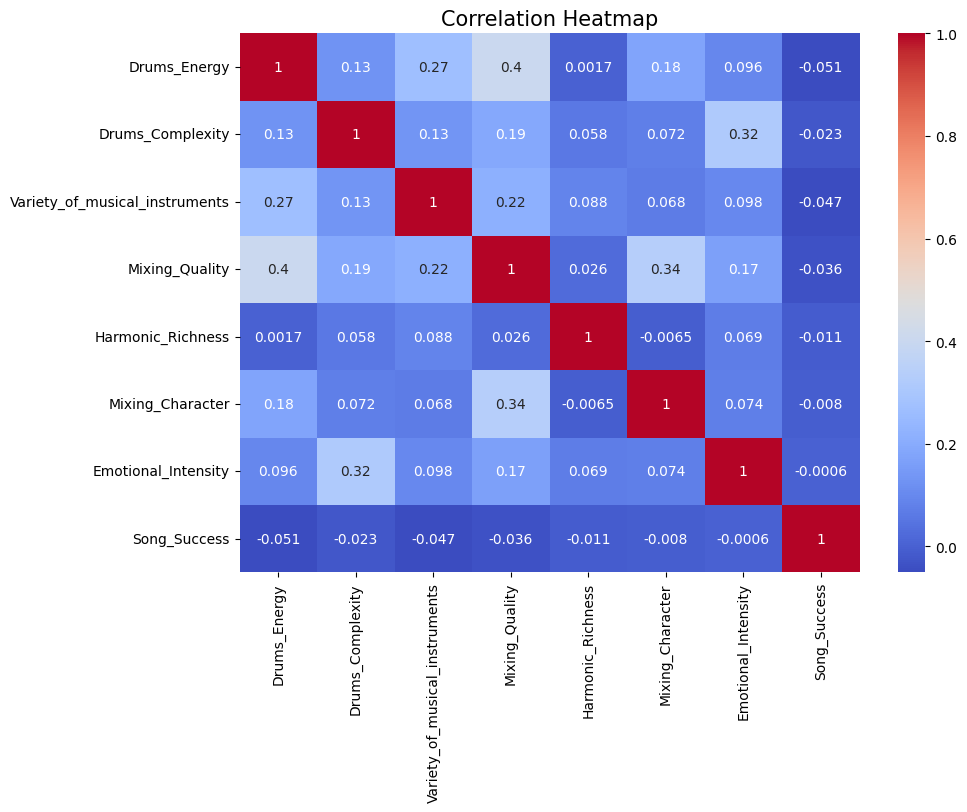

In [175]:
plt.figure(figsize = (10,7))
corr_df = sns.heatmap(tecnikal_info.corr(), cmap='coolwarm', annot=True, fmt='0.2g');
corr_df.set_title('Correlation Heatmap', fontsize = 15);

Все отрицательное...
Дальше аргументируем почему так

In [176]:
pd.DataFrame(tecnikal_info.corrwith(y_encoded), columns = ['corr with Song_Success']).T

,Drums_Energy,Drums_Complexity,Variety_of_musical_instruments,Mixing_Quality,Harmonic_Richness,Mixing_Character,Emotional_Intensity,Song_Success
corr with Song_Success,-0.05085,-0.022644,-0.047213,-0.036238,-0.010651,-0.007979,-0.000601,1.0


Корреляция отрицательна по каждому признаку с таргетом: все должно быть в балансе, завышение данных характеристик приводит к снижению популярности песни

In [177]:
tecnikal_info.describe()

,Drums_Energy,Drums_Complexity,Variety_of_musical_instruments,Mixing_Quality,Harmonic_Richness,Mixing_Character,Emotional_Intensity,Song_Success
count,14396.000000,14396.000000,14396.000000,14396.000000,14396.000000,14396.000000,14396.000000,14396.000000
mean,0.972291,0.954719,0.971833,0.911140,0.967889,0.968090,0.957329,0.184982
std,0.480417,0.511500,0.479232,0.577598,0.519323,0.503228,0.485440,0.388296
min,0.496253,0.419928,0.525140,0.480746,0.424486,0.499828,0.303615,0.000000
25%,0.642970,0.601721,0.643660,0.575507,0.644270,0.638971,0.645383,0.000000
50%,0.794795,0.762141,0.778829,0.697767,0.752739,0.772494,0.786227,0.000000
75%,1.143000,1.127406,1.151426,1.029087,1.099093,1.120537,1.145316,0.000000
max,7.112194,5.690766,6.588165,7.567636,7.625900,6.015559,4.828630,1.000000


6) Какие средние значения барабанной дроби для хитов и непопулярных треков?

In [178]:
tecnikal_info.groupby(by = 'Song_Success').mean()

,Drums_Energy,Drums_Complexity,Variety_of_musical_instruments,Mixing_Quality,Harmonic_Richness,Mixing_Character,Emotional_Intensity
Song_Success,,,,,,,
0,0.983928,0.960237,0.982612,0.921111,0.970524,0.970003,0.957468
1,0.921015,0.930407,0.924343,0.867206,0.956279,0.959663,0.956717


Можно заметить, что средние характеристики у успешных треков (1) занижены в сравнении с таргет (0) по всем признакам. Посмотрим на таблицу характеристик из пункта 5, все средние значения в группе неудачных треков выше чем средние по генеральной совокупности.

В итоге подтвердилась отрицательная корреляция с таргетом (см хитмэп): большие значения признаков отрицательно влияют на популярность песни. Поясним: существуют определенные звуки, которые из-за своей интенсивности или в целом специфичности характеристик тяжелы для восприятия человеком: например высокие частоты, сложные тяжелые басы, шум/скрежет/искаженные звуки и тд, неадекватные ритмы. Большая вариантивность музыкальных инструментов при неумелом сочетании может создать звуковую кашу, которую тоже станет невозможно слушать равно или поздно. Было замечено, что все средние характеристики плохих треков были выше средних значений - индикатор того, что музыку перегрузили и могли сделать неприятной для человеческого уха (?)


Дописать сюда что значит каждый из признаков.

# 3. Что будет дальше?

План работ:
1.  Закончить парсинг
2. Выбрать итоговые гипотезы
3. Модель классификация бинарная: просто логрег налепить
